# Airline time delay prediction

The aim of this Data Workshop kaggle challenge was to predict delay of airplane based on set of features. 

In this project I've used my own ideas, as well as some solutions implemented by other participants of competition.

In [3]:
import pandas as pd
import numpy as np
np.random.seed(2019)
from collections import defaultdict
import arrow

from sklearn.dummy import DummyRegressor,DummyClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold 
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_log_error, make_scorer
import scikitplot as skplt
from ml_metrics import rmsle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import xgbfir
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

import warnings
warnings.filterwarnings('ignore')

#### Data loading

Data is divided into train set and test set. Train was used in model building, test was used only for Kaggle validation.

In [4]:
train = pd.read_hdf('train_airline_delay.h5') 
test = pd.read_csv('test_airline_delay.csv') 

Additional data sources:

In [3]:
airports = pd.read_csv('airports.csv')
carriers = pd.read_csv('carriers.csv')
tail_number = pd.read_csv('tail_number.csv')
airports_timezones = pd.read_csv('timezones_iata.csv')

print(airports.shape, carriers.shape, tail_number.shape, airports_timezones.shape)

(3376, 7) (21, 3) (5029, 9) (9184, 3)


#### Data analysis

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077114 entries, 0 to 1077113
Data columns (total 28 columns):
year                        1077114 non-null int8
month                       1077114 non-null int8
actual_departure_time       1056256 non-null float32
day_of_month                1077114 non-null int8
day_of_week                 1077114 non-null int8
scheduled_departure_time    1077114 non-null float32
actual_arrival_time         1056195 non-null float32
scheduled_arrival_time      1077114 non-null float32
air_time                    1056195 non-null float16
arrival_delay               1056195 non-null float16
depature_delay              1056256 non-null float16
carrier_id                  1077114 non-null int8
flight_number               1077114 non-null int16
tail_number                 1077114 non-null int16
actual_elapsed_time         1056195 non-null float16
scheduled_elapsed_time      1077088 non-null float16
origin                      1077114 non-null object
destin

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078310 entries, 0 to 1078309
Data columns (total 15 columns):
id                          1078310 non-null int64
year                        1078310 non-null int64
month                       1078310 non-null int64
day_of_month                1078310 non-null int64
day_of_week                 1078310 non-null int64
scheduled_departure_time    1078310 non-null float64
scheduled_arrival_time      1078310 non-null float64
carrier_id                  1078310 non-null int64
flight_number               1078310 non-null int64
tail_number                 1078310 non-null int64
scheduled_elapsed_time      1078280 non-null float64
origin                      1078310 non-null object
destination                 1078310 non-null object
distance                    1078310 non-null int64
target_delay                0 non-null float64
dtypes: float64(4), int64(9), object(2)
memory usage: 123.4+ MB


In [7]:
train.columns[train.isnull().any()]

Index(['actual_departure_time', 'actual_arrival_time', 'air_time',
       'arrival_delay', 'depature_delay', 'actual_elapsed_time',
       'scheduled_elapsed_time', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [8]:
test.columns[test.isnull().any()]

Index(['scheduled_elapsed_time', 'target_delay'], dtype='object')

In [9]:
test.drop('id', inplace=True, axis=1)

Some columns are available in train data set but they're not present in test set. There're missing values. Most of features are numerical, however in fact most of them represents categories. 

In [10]:
train.sample(5)

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,...,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay
858475,2,3,1034.0,15,6,1048.0,1215.0,1225.0,75.0,-10.0,...,466,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0
458980,0,2,1359.0,26,7,1400.0,1932.0,2000.0,199.0,-28.0,...,1745,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
1048252,1,11,656.0,9,5,700.0,843.0,845.0,87.0,-2.0,...,293,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
1015657,2,6,1646.0,29,7,1650.0,1901.0,1908.0,118.0,-7.0,...,714,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0
445351,0,10,915.0,31,2,917.0,1033.0,1040.0,63.0,-7.0,...,297,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0


In [11]:
test.sample(5)

,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay
415532,0,4,23,7,700.0,854.0,15,848,3888,234.0,ORD,LAS,1515,NaN
1011184,0,2,17,5,615.0,730.0,1,2003,760,75.0,CLE,BWI,314,NaN
45501,0,1,19,4,1512.0,1641.0,8,666,2350,89.0,ATL,RIC,481,NaN
306152,0,1,23,1,1158.0,1236.0,4,4111,1280,38.0,LAX,SBA,89,NaN
899607,0,10,28,6,820.0,1620.0,6,5917,1656,300.0,ITO,OAK,2329,NaN


In [12]:
airports.sample(5)

,iata,airport,city,state,country,lat,long
2358,MYK,May Creek,May Creek,AK,USA,61.335674,-142.686775
201,20A,Robbins,Oneonta,AL,USA,33.972320,-86.379427
2569,P04,Bisbee Municipal,Bisbee,AZ,USA,31.363990,-109.883129
1529,FNB,Brenner,Falls City,NE,USA,40.078786,-95.591992
408,49A,Gilmer County,Ellijay,GA,USA,34.627864,-84.524929


In [13]:
airports.isnull().any()

iata       False
airport    False
city        True
state       True
country    False
lat        False
long       False
dtype: bool

In [15]:
airports[airports['state'].isnull()]

,iata,airport,city,state,country,lat,long
1136,CLD,MC Clellan-Palomar Airport,NaN,NaN,USA,33.127231,-117.278727
1715,HHH,Hilton Head,NaN,NaN,USA,32.224384,-80.697629
2251,MIB,Minot AFB,NaN,NaN,USA,48.415769,-101.358039
2312,MQT,Marquette County Airport,NaN,NaN,USA,46.353639,-87.395361
2752,RCA,Ellsworth AFB,NaN,NaN,USA,44.145094,-103.103567
2759,RDR,Grand Forks AFB,NaN,NaN,USA,47.961167,-97.401167
2794,ROP,Prachinburi,NaN,NaN,Thailand,14.078333,101.378334
2795,ROR,Babelthoup/Koror,NaN,NaN,Palau,7.367222,134.544167
2900,SCE,University Park,NaN,NaN,USA,40.851206,-77.846302
2964,SKA,Fairchild AFB,NaN,NaN,USA,47.615058,-117.655803


In order to improve performance of features based on airports data set, some values have been filled manualy based on prepared dictionary visible below.

In [16]:
missing = {'MQT':'MI','CLD':'CA','HHH':'NC','SCE':'PA',
           'MIB':'ND','RCA':'SD','RDR':'ND','ROP':'THA',
           'ROR':'PAL','SKA':'WA','SPN':'NMI','YAP':'YAP'}

airports['state'] = airports['state'].fillna(airports['iata'].map(missing))

In [17]:
carriers.sample(5)

,code,description,id
2,AQ,Aloha Airlines Inc.,19
12,NW,Northwest Airlines Inc.,14
17,US,US Airways Inc. (Merged with America West 9/05...,0
6,DL,Delta Air Lines Inc.,8
1,AA,American Airlines Inc.,15


In [18]:
tail_number.sample(5)

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,id
2555,Corporation,MCDONNELL DOUGLAS,09/30/1991,DC-9-82(MD-82),Valid,Fixed Wing Multi-Engine,Turbo-Fan,1991,3928.0
2582,Corporation,CANADAIR,06/30/1995,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1995,1094.0
3071,Corporation,AIRBUS INDUSTRIE,06/04/2004,A320-232,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1999,250.0
2398,Corporation,BOEING,02/22/2006,757-222,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992,1700.0
2843,Corporation,BOEING,12/13/1995,737-3H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1995,476.0


In [19]:
airports_timezones.sample(5)

,Unnamed: 0,code,tz
7210,7210,STL,America/Chicago
640,640,BES,Europe/Paris
5440,5440,NUA,Asia/Colombo
2993,2993,HMA,Asia/Yekaterinburg
7098,7098,SOR,Asia/Damascus


Additional feature containing numerical time zone has been added. 

In [20]:
airports_timezones['zones_num'] = airports_timezones['tz'].factorize()[0]

Very important assumption in this challenge concerns canceled flights. When it happens, values of delay is set to 3 days (4320 minutes). I've performed some experiments to implement model predicting, if the plane will be cancelled, however it was not successful to get satisfactionary value of precision and recall. As a result of number of experiments, it turned out that model is capable of predicting cancelation in main regression model.
Looking at data shows that most of cancelled flights depends on tail number. 
There are columns in train set which are not available in test data, I've decided not to use it.

In [21]:
train[train['is_cancelled']==1][['carrier_id', 'tail_number']].groupby(['tail_number']).agg(
    'count').reset_index().sort_values(by='carrier_id', ascending=False).iloc[:20, ]

,tail_number,carrier_id
4,10,8980
0,-1,4093
578,1679,1074
241,960,39
161,875,31
845,2427,30
135,847,28
848,2430,25
145,857,25
222,941,24


There are 8980 cancelled flights for tail number 10. Tail number in this case is very important.

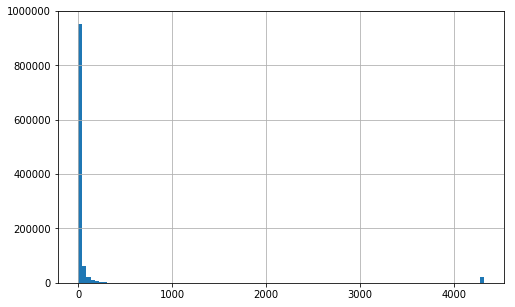

In [22]:
train['target_delay'].hist(bins=100, figsize=(8,5))
plt.show()

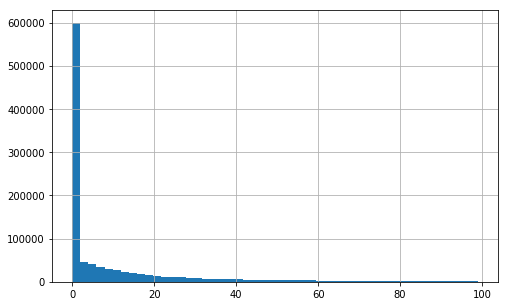

In [23]:
train[train['target_delay']<100]['target_delay'].hist(bins=50, figsize=(8,5))
plt.show()

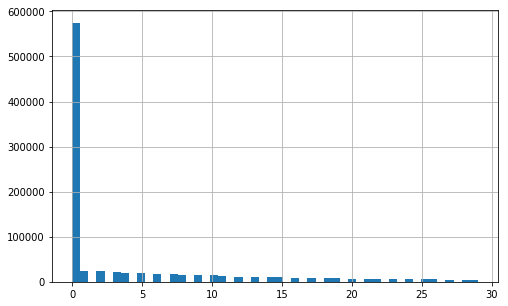

In [24]:
train[train['target_delay']<30]['target_delay'].hist(bins=50, figsize=(8,5))
plt.show()

Target variable is heavy tailed. Vast majority of delay are about 0 minutes. There are also values 4320 - cancelled flights. Logarithmic tranformation is recommended to improve performance.

Merging train and test with additional data sets:

In [25]:
train = train.merge(tail_number, left_on='tail_number',
                    right_on='id', suffixes=('_train', '_tail'), how='left')
train = train.merge(airports, left_on='origin', right_on='iata',
                    suffixes=('_train', '_air_origin'), how='left')
train = train.merge(airports, left_on='destination',
                    right_on='iata', suffixes=('_orig', '_dest'), how='left')

test = test.merge(tail_number, left_on='tail_number',
                  right_on='id', suffixes=('_train', '_tail'), how='left')
test = test.merge(airports, left_on='origin', right_on='iata',
                  suffixes=('_train', '_air_origin'), how='left')
test = test.merge(airports, left_on='destination',
                  right_on='iata', suffixes=('_orig', '_dest'), how='left')

print(train.shape, test.shape)

(1077114, 51) (1078310, 37)


Additional transformations:

In [26]:
train['carrier_delay'] = train.apply(lambda x: 0 if (x['target_delay'] == 0) | (
    x['target_delay']==4320) else x['carrier_delay'], axis=1)
train['carrier_delay'] = train.apply(
    lambda x: 4320 if x['cancellation_code'] == 1 else x['carrier_delay'], axis=1)
train['is_delayed_10'] = train.apply(
    lambda x: 1 if x['target_delay'] > 10 else 0, axis=1)

train.fillna(-1, inplace=True)

### Visualizations

In order to investigate data and find interesting features I've prepared some visualizations.

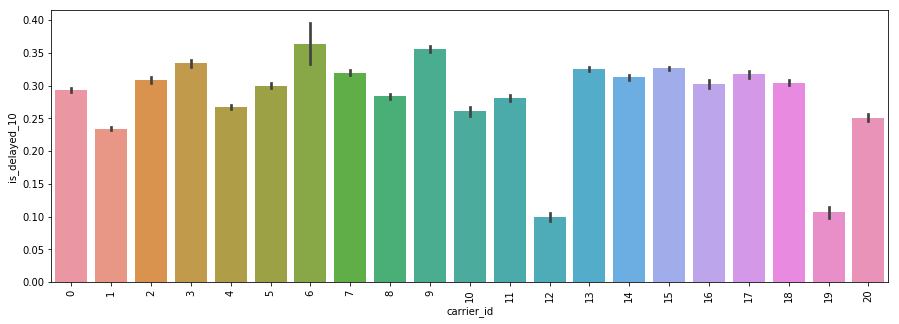

In [28]:
plt.figure(figsize=(15, 5))
sns.barplot(x='carrier_id', y="is_delayed_10", data=train)
plt.xticks(rotation=90);

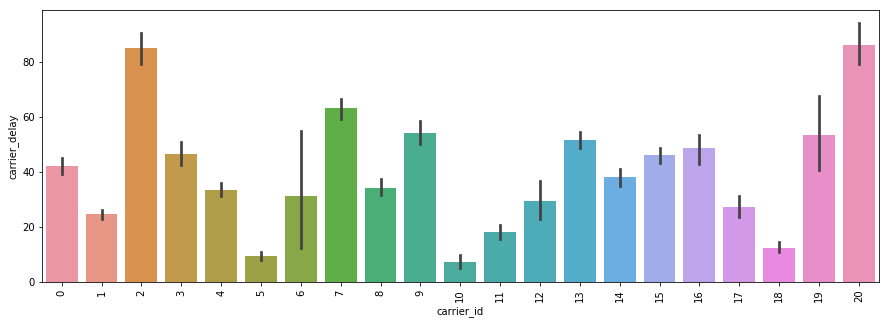

In [29]:
plt.figure(figsize=(15, 5))
sns.barplot(x='carrier_id', y="carrier_delay", data=train)
plt.xticks(rotation=90);

It is visible that some carriers have high values of delay and some has small. Carrier might be important. 

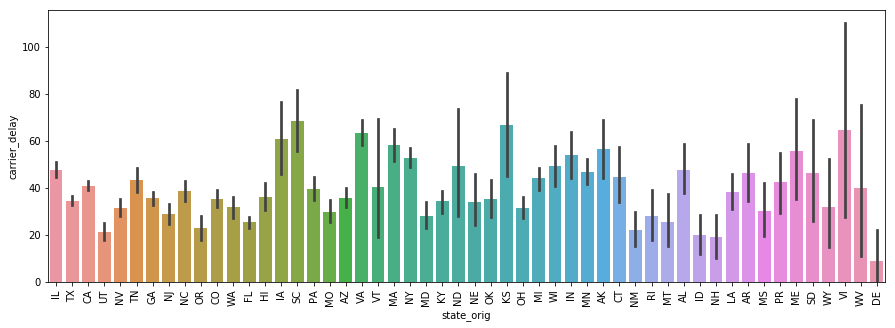

In [30]:
plt.figure(figsize=(15, 5))
sns.barplot(x='state_orig', y="carrier_delay", data=train)
plt.xticks(rotation=90);

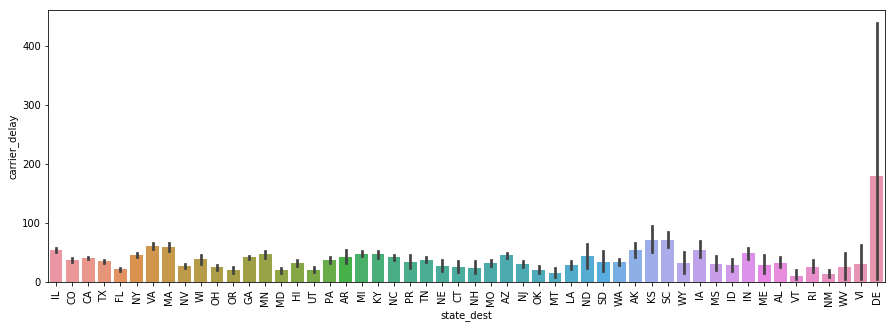

In [31]:
plt.figure(figsize=(15, 5))
sns.barplot(x='state_dest', y="carrier_delay", data=train)
plt.xticks(rotation=90);

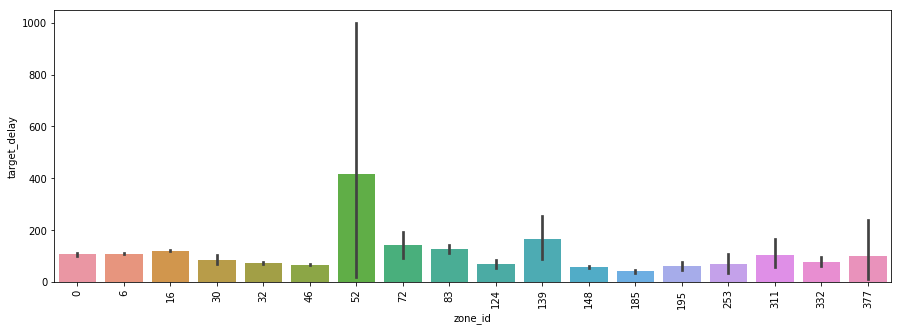

In [46]:
plt.figure(figsize=(15, 5))
sns.barplot(x='zone_id', y="target_delay", data=train)
plt.xticks(rotation=90);

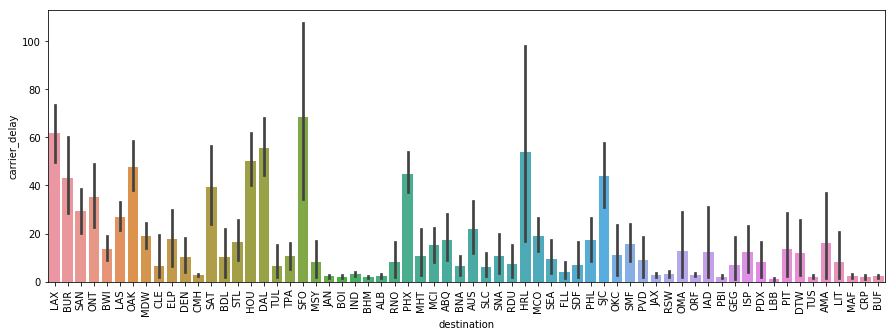

In [34]:
carrier=train[train['carrier_id']==1]
plt.figure(figsize=(15, 5))
sns.barplot(x='destination', y="carrier_delay", data=carrier)
plt.xticks(rotation=90);

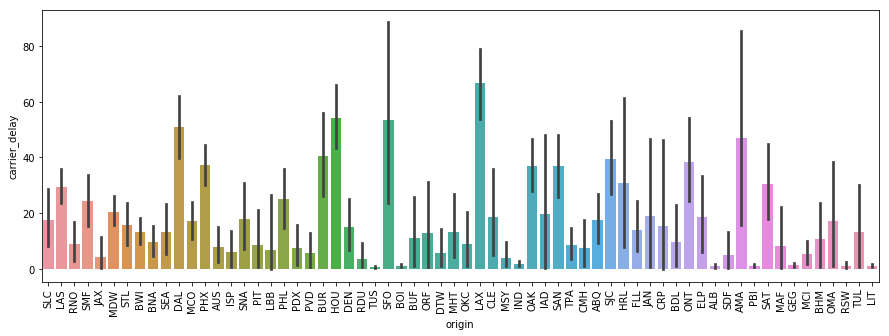

In [35]:
plt.figure(figsize=(15, 5))
sns.barplot(x='origin', y="carrier_delay", data=carrier)
plt.xticks(rotation=90);

In [36]:
most_common_tail = list(train['tail_number'].value_counts().head(50).to_dict().keys())

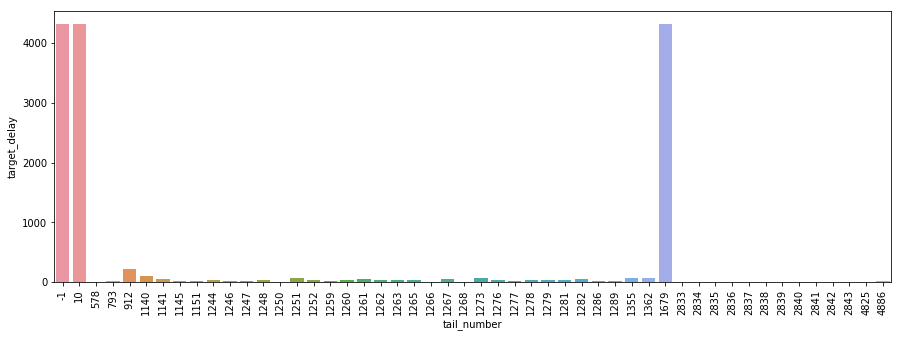

In [37]:
most_common_tail_df = train[train['tail_number'].isin(most_common_tail)][[
    'tail_number', 'target_delay']].groupby('tail_number').agg(np.mean).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(x='tail_number', y="target_delay", data=most_common_tail_df)
plt.xticks(rotation=90)

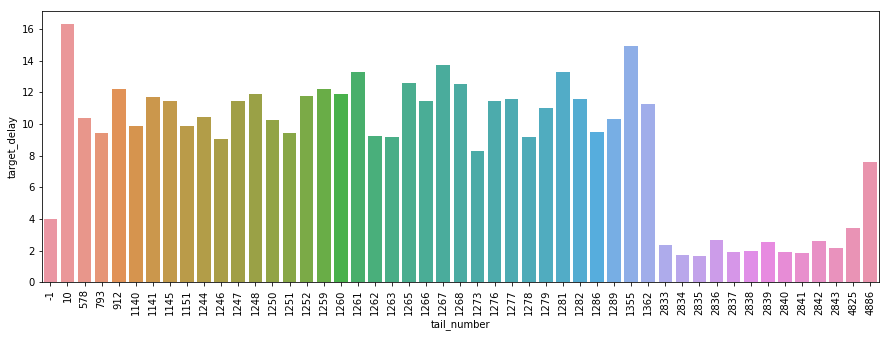

In [38]:
most_common_tail_df = train[(train['tail_number'].isin(most_common_tail)) & (train['target_delay'] < 500)][[
    'tail_number', 'target_delay']].groupby('tail_number').agg(np.mean).reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(x='tail_number', y="target_delay", data=most_common_tail_df)
plt.xticks(rotation=90)

This visualization shows that mean of delay depends on tail number. Divesrsity of mean delay for tail number is meaningful, it is important to remember that cancellation is strictly connected with tail number.

### Feature engineering

Feature engineering has been performed using my own ideas as well as with the use of some features discovered by other participators. 

In [39]:
def feat_eng(train, test):
    
    train['carrier_delay'] = train.apply(lambda x: 0 if (x['target_delay'] == 0) | (
        x['target_delay']==4320) else x['carrier_delay'], axis=1)
    train['carrier_delay'] = train.apply(
        lambda x: 4320 if x['cancellation_code'] == 1 else x['carrier_delay'], axis=1)
    train['is_delayed_10'] = train.apply(
        lambda x: 1 if x['target_delay'] > 10 else 0, axis=1)

    all = pd.concat([train[list(test.columns)], test],
                    axis=0, ignore_index=True)

    unique_categories = list(set(train['origin']))
    for airport in unique_categories:
        all.loc[all['origin'] == airport,
                'zone_id'] = airports_timezones['zones_num'][airports_timezones['code'] == airport].values[0]
    all = all.fillna(-1)
    all['zone_id'] = all['zone_id'].map(lambda x: int(x))

    for f in [['carrier_id'], ['origin'], ['destination']]:
        dict_agg = train[f+['carrier_delay']
                         ].groupby(f).agg(np.mean).to_dict()['carrier_delay']
        
        default_dict_val = np.mean(list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)
        
        name = 'agg_{}_carrier_delay_mean'.format(f[0])
        all[name] = all[f[0]].map(lambda x: default_dict_agg[x])

    for f in [['tail_number'], ['carrier_id']]:
        dict_agg = train[f+['is_delayed_10']
                         ].groupby(f).agg(np.mean).to_dict()['is_delayed_10']
        
        default_dict_val = np.mean(list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)
        
        name = 'agg_{}_is_delayed_10_mean'.format(f[0])
        all[name] = all[f[0]].map(lambda x: default_dict_agg[x])

    all['origin_cat'] = pd.factorize(all['origin'])[0]
    all['dest_cat'] = pd.factorize(all['destination'])[0]
    all['origin_dest'] = all[['origin', 'destination']].apply(
        lambda x: '{0}-{1}'.format(x['origin'], x['destination']), axis=1)
    all['origin_dest_cat'] = pd.factorize(all['origin_dest'])[0]

    all['tail_carrier'] = all[['tail_number', 'carrier_id']].apply(
        lambda x: '{0}-{1}'.format(x['tail_number'], x['carrier_id']), axis=1)
    all['tail_carrier_cat'] = pd.factorize(all['tail_carrier'])[0]
    all['tail_year'] = all[['tail_number', 'year_train']].apply(
        lambda x: '{0}-{1}'.format(x['tail_number'], x['year_train']), axis=1)
    all['tail_year_cat'] = pd.factorize(all['tail_carrier'])[0]

    all['scheduled_departure_hour'] = all['scheduled_departure_time'].map(
        lambda x: int(np.floor(x/100)))
    all['scheduled_arrival_time'] = all['scheduled_arrival_time'].map(
        lambda x: int(x))

    all['state_orig_cat'] = pd.factorize(all['state_orig'])[0]
    all['state_dest_cat'] = pd.factorize(all['state_dest'])[0]

    all['tail_number_10'] = all['tail_number'] == 10
    all['tail_number_un'] = all['tail_number'] == -1

    print(all.shape)
    return all

In [40]:
%time all = feat_eng(train,test)

(2155424, 56)
CPU times: user 4min 33s, sys: 11.3 s, total: 4min 44s
Wall time: 4min 44s


Based on analysis set of features has been choosen to further calculations.

In [41]:
feat= ['year_train', 'month', 'day_of_month', 'day_of_week','flight_number', 
       'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id',
       'scheduled_elapsed_time', 'origin','year_tail', 'tail_number',
       'destination', 'distance', 'target_delay', 'type', 'manufacturer','issue_date',       
       'state_orig', 'lat_orig', 'long_orig', 'state_dest', 'lat_dest',
       'long_dest', 'agg_carrier_id_carrier_delay_mean',
       'agg_origin_carrier_delay_mean', 'agg_destination_carrier_delay_mean',
       'agg_tail_number_is_delayed_10_mean', 'origin_cat', 'dest_cat',
       'origin_dest_cat', 'tail_carrier_cat','tail_year_cat', 'scheduled_departure_hour',
       'state_orig_cat', 'state_dest_cat', 'agg_carrier_id_is_delayed_10_mean',
       'tail_number_10', 'tail_number_un','zone_id']

all[feat].to_csv('all10_1.csv') 

In [2]:
all = pd.read_csv('all10_1.csv')
print(all.shape)

(2155424, 41)


In [3]:
test = all[all['target_delay']==-1]
train = all[all['target_delay']!=-1]

train = train.fillna(-1)
test = test.fillna(-1)

print(train.shape,test.shape)

(1077114, 41) (1078310, 41)


### Models

I've prepared two models using XGBRegressor. First has more features but the value of max depth and min_child_weight are lower, second model has less features but higher depth and min_child_weight. Both have been validated during cross validation. 

In [4]:
features1 = ['year_train', 'month', 'day_of_month', 'day_of_week',
            'origin_cat','dest_cat','tail_number','carrier_id', 'distance',
            'scheduled_departure_hour','scheduled_arrival_time',
            'state_orig_cat','state_dest_cat','lat_orig','long_orig','lat_dest', 'long_dest',
            'tail_number_10','tail_number_un','agg_carrier_id_carrier_delay_mean',
            'agg_tail_number_is_delayed_10_mean','agg_carrier_id_is_delayed_10_mean']

features2 = ['year_train', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time', 'scheduled_arrival_time', 'scheduled_elapsed_time',
            'origin_cat', 'dest_cat', 'tail_carrier_cat', 'tail_year_cat', 'origin_dest_cat',
            'tail_number','carrier_id', 'distance','flight_number', 'zone_id']

#### Model #1

In [ ]:
def scoring(m, y_true, y_log_pred):
    y_pred = np.expm1(y_log_pred)
    score = rmsle(y[test_idx], y_pred)
    
    print(m + " RMSLE: ", score)
    scores[m + '_RMSLE'].append(score)

In [ ]:
X = train[features1].values
y_log = np.log1p(train['target_delay'])
y = train['target_delay']

model = xgb.XGBRegressor(max_depth=12, n_estimators=120, learning_rate=0.1,
                         n_jobs=8, random_state=2019, min_child_weight=2)

In [47]:
scores = {'xgb_RMSLE': []}
cv = KFold(n_splits=5, shuffle=True, random_state=2018)

fold = 0
for train_idx, test_idx in cv.split(X):
    fold += 1
    print("fold: ", fold)
    model.fit(X[train_idx], y_log[train_idx])
    
    y_log_pred = model.predict(X[test_idx])
    scoring('xgb', y_log[test_idx], y_log_pred)

for s in scores:
    print(s, np.mean(scores[s]), np.std(scores[s]))

fold:  1
xgb RMSLE:  1.526824688145908
fold:  2
xgb RMSLE:  1.5302244287921298
fold:  3
xgb RMSLE:  1.5300142302069324
fold:  4
xgb RMSLE:  1.5284320829122855
fold:  5
xgb RMSLE:  1.529498498656617
xgb_RMSLE 1.5289987857427745 0.0012514706388299954


#### Model #2

In [ ]:
X = train[features2].values
y_log = np.log1p(train['target_delay'])
y = train['target_delay']

model = xgb.XGBRegressor(max_depth=14, n_estimators=120, learning_rate=0.1,
                         n_jobs=8, min_child_weight=8, random_state=2019)

In [48]:
scores = {'xgb_RMSLE' : []}
cv = KFold(n_splits=5, shuffle=True, random_state=2018)

fold = 0
for train_idx, test_idx in cv.split(X):
    fold += 1
    print("fold: ", fold)    
    model.fit(X[train_idx], y_log[train_idx])
    
    y_log_pred = model.predict(X[test_idx])
    scoring('xgb', y_log[test_idx], y_log_pred)
           
for s in scores:
    print(s, np.mean(scores[s]), np.std(scores[s]))

fold:  1
xgb RMSLE:  1.535342614072116
fold:  2
xgb RMSLE:  1.5403940393164552
fold:  3
xgb RMSLE:  1.5388995781852923
fold:  4
xgb RMSLE:  1.5398913507317618
fold:  5
xgb RMSLE:  1.5399198264797114
xgb_RMSLE 1.5388894817570673 0.0018389898015955229


### Learning curves

In [5]:
def rmse(y, y0):
     return np.sqrt(np.mean(np.square(y-y0))) 
    
rmse_score = make_scorer(rmse, greater_is_better=False) 

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 4)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=rmse_score, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

Model #1

<module 'matplotlib.pyplot' from '/home/liber1320/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

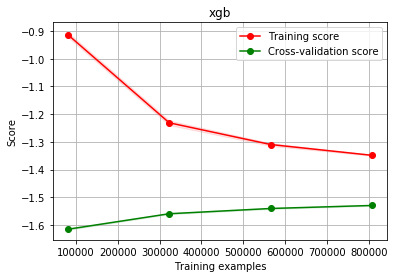

In [51]:
X = train[features1].values
y_log = np.log1p(train['target_delay'])

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = xgb.XGBRegressor(max_depth=12, n_estimators=120, learning_rate=0.1,
                         n_jobs=10, random_state=2019, min_child_weight=2)

plot_learning_curve(model, 'xgb', X, y_log, cv=cv, n_jobs=10)

Model #2

<module 'matplotlib.pyplot' from '/home/liber1320/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

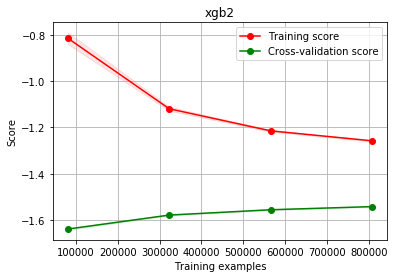

In [7]:
X = train[features2].values
y_log = np.log1p(train['target_delay'])
y = train['target_delay']

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = xgb.XGBRegressor(max_depth=14, n_estimators=120, learning_rate=0.1,
                         n_jobs=10, min_child_weight=8, random_state=2019)

plot_learning_curve(model, 'xgb2', X, y_log, cv=cv)

### Eli5 and xgbfir 

Eli5 algorithm and xgbfir have been used to analyse feature importance.

#### Model #1

In [53]:
X = train[features1].values
y_log = np.log1p(train['target_delay'])

model = xgb.XGBRegressor(max_depth=12, n_estimators=120, learning_rate=0.1, 
                         n_jobs=8,random_state=2019, min_child_weight=2)
model.fit(X,y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=2, missing=None, n_estimators=120, n_jobs=8,
       nthread=None, objective='reg:linear', random_state=2019,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Weight

In [54]:
eli5.show_weights(model, feature_names=features1, top=50)

Weight,Feature
0.2698,agg_tail_number_is_delayed_10_mean
0.0687,scheduled_departure_hour
0.0608,agg_carrier_id_is_delayed_10_mean
0.0486,long_orig
0.0485,year_train
0.0474,long_dest
0.0442,month
0.0430,agg_carrier_id_carrier_delay_mean
0.0394,carrier_id
0.0370,day_of_month


Gain

In [55]:
eli5.show_weights(model.get_booster(), feature_names=features1, top=50) 

Weight,Feature
0.2698,agg_tail_number_is_delayed_10_mean
0.0687,scheduled_departure_hour
0.0608,agg_carrier_id_is_delayed_10_mean
0.0486,long_orig
0.0485,year_train
0.0474,long_dest
0.0442,month
0.0430,agg_carrier_id_carrier_delay_mean
0.0394,carrier_id
0.0370,day_of_month


Cover

In [56]:
eli5.explain_weights_xgboost(model.get_booster(), feature_names=features1, top=50, importance_type='cover') 

Weight,Feature
0.0832,long_dest
0.0763,long_orig
0.0758,carrier_id
0.0736,origin_cat
0.0660,agg_carrier_id_is_delayed_10_mean
0.0605,scheduled_departure_hour
0.0564,agg_carrier_id_carrier_delay_mean
0.0563,dest_cat
0.0483,month
0.0467,lat_orig


xgbfir

In [57]:
xgbfir.saveXgbFI(model, feature_names=features1, OutputXlsxFile='model1.xlsx')
pd.read_excel('model1.xlsx', 'Interaction Depth 0')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,agg_tail_number_is_delayed_10_mean,4.194510e+06,20054,116.035219,0.005786,209.160759,3.767531e+06,1,3,2,12,1,1,3.333333,54.061584,9.790665
1,day_of_month,6.555828e+05,24506,91.412059,0.003730,26.751929,5.968379e+03,2,1,4,20,10,8,7.500000,48.486452,9.709092
2,month,5.612183e+05,17133,125.418164,0.007320,32.756569,1.846508e+04,3,5,1,9,7,4,4.833333,48.514971,9.542695
3,scheduled_arrival_time,4.667898e+05,19871,92.053772,0.004633,23.491005,1.511460e+05,4,4,3,17,14,3,7.500000,52.161844,9.735444
4,scheduled_departure_hour,3.463178e+05,6476,59.059968,0.009120,53.477120,2.064427e+05,5,15,10,6,2,2,6.666667,54.001699,9.648085
5,day_of_week,3.079715e+05,11601,71.148544,0.006133,26.546983,5.951503e+03,6,6,8,11,11,9,8.500000,48.903629,9.647703
6,tail_number,2.816843e+05,20746,85.150601,0.004104,13.577765,1.606576e+03,7,2,5,19,20,15,11.333333,54.257062,9.802227
7,year_train,2.814040e+05,7993,38.618038,0.004831,35.206310,3.517119e+03,8,8,14,15,4,10,9.833333,45.205305,9.579757
8,long_dest,2.381653e+05,7061,77.251582,0.010941,33.729684,7.632327e+03,9,11,6,1,6,7,6.666667,44.472029,9.618184
9,long_orig,2.378445e+05,6763,69.364057,0.010256,35.168494,8.692297e+03,10,12,9,3,5,6,7.500000,42.687417,9.651486


#### Model #2

In [58]:
X = train[features2].values
y_log = np.log1p(train['target_delay'])

model2 = xgb.XGBRegressor(max_depth=14, n_estimators=120, learning_rate=0.1,
                          n_jobs=10, min_child_weight=8,random_state=2019)
model2.fit(X, y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=8, missing=None, n_estimators=120, n_jobs=10,
       nthread=None, objective='reg:linear', random_state=2019,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Weight

In [59]:
eli5.show_weights(model2, feature_names=features2, top=50)

Weight,Feature
0.2071,tail_number
0.1528,carrier_id
0.0815,zone_id
0.0659,year_train
0.0611,month
0.0504,day_of_month
0.0483,day_of_week
0.0468,scheduled_departure_time
0.0456,dest_cat
0.0451,origin_cat


Gain

In [60]:
eli5.show_weights(model2.get_booster(), feature_names=features2, top=50) 

Weight,Feature
0.2071,tail_number
0.1528,carrier_id
0.0815,zone_id
0.0659,year_train
0.0611,month
0.0504,day_of_month
0.0483,day_of_week
0.0468,scheduled_departure_time
0.0456,dest_cat
0.0451,origin_cat


Cover

In [61]:
eli5.explain_weights_xgboost(model2.get_booster(), feature_names=features2, top=50, importance_type='cover') 

Weight,Feature
0.1017,carrier_id
0.0974,dest_cat
0.0964,distance
0.0955,origin_cat
0.0758,zone_id
0.0706,month
0.0617,scheduled_elapsed_time
0.0612,tail_number
0.0510,year_train
0.0466,scheduled_arrival_time


xgbfir

In [62]:
xgbfir.saveXgbFI(model2, feature_names=features2, OutputXlsxFile='model2.xlsx')
pd.read_excel('model2.xlsx', 'Interaction Depth 0')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,tail_number,3.744550e+06,35721,163.304422,0.004572,104.827681,2.980817e+06,1,1,1,7,1,1,2.000000,43.142073,11.434842
1,day_of_month,7.734253e+05,31718,87.498567,0.002759,24.384428,5.042257e+03,2,3,8,14,6,10,7.166667,40.765275,11.266631
2,month,5.797239e+05,19312,116.299259,0.006022,30.018842,2.622762e+04,3,9,4,5,5,5,5.166667,44.055613,11.118372
3,scheduled_departure_time,5.724292e+05,25018,85.434093,0.003415,22.880695,2.221960e+05,4,5,9,11,8,2,6.500000,45.242226,11.475178
4,tail_carrier_cat,5.430305e+05,35240,94.745487,0.002689,15.409493,4.020421e+03,5,2,7,15,13,11,8.833333,46.296708,11.488848
5,scheduled_arrival_time,5.018409e+05,24902,83.810870,0.003366,20.152635,1.513084e+05,6,6,10,12,11,3,8.000000,43.883825,11.409485
6,carrier_id,4.531964e+05,6103,48.286678,0.007912,74.257966,1.707153e+04,7,16,14,1,2,6,7.666667,37.227429,10.970342
7,dest_cat,3.838489e+05,17751,121.114249,0.006823,21.624069,8.155209e+03,8,10,2,4,9,8,6.833333,38.452031,11.289279
8,flight_number,3.818695e+05,29209,77.486447,0.002653,13.073692,1.651700e+03,9,4,11,16,16,15,11.833333,44.254305,11.445548
9,day_of_week,3.611971e+05,15222,60.953222,0.004004,23.728621,7.117661e+03,10,12,12,10,7,9,10.000000,42.237748,11.256734


Analysis provides evidences that both weight, cover and gain should be taken into consideration. Features from aggregation look like most important. We should notice that for example longitude and latitude are on first places in cover analysis but it may concern only small part of data. 
Results varies between models. It is possible that one feature can dominate others and change results. 

#### Final training and preparing validation data set

In [5]:
X = train[features1].values
y_log = np.log1p(train['target_delay'])

model = xgb.XGBRegressor(max_depth=12, n_estimators=120, learning_rate=0.1, 
                         n_jobs=12,random_state=2019,min_child_weight=2)
model.fit(X, y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=2, missing=None, n_estimators=120, n_jobs=12,
       nthread=None, objective='reg:linear', random_state=2019,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [6]:
X_t = test[features1].values
y_pred_log = model.predict(X_t)
y_pred = np.expm1(y_pred_log)

test['target_delay1'] = y_pred
test['target_delay1'] = test['target_delay1'].apply(lambda x: 4320 if x>3000 else x)
test['target_delay1'] = test['target_delay1'].apply(lambda x: 0 if x<0 else x)

In [7]:
X = train[features2].values
y_log = np.log1p(train['target_delay'])

model2 = xgb.XGBRegressor(max_depth=14, n_estimators=120, learning_rate=0.1, 
                          n_jobs=12, min_child_weight=8,random_state=2019)
model2.fit(X, y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=8, missing=None, n_estimators=120, n_jobs=12,
       nthread=None, objective='reg:linear', random_state=2019,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
X_t = test[features2].values
y_pred_log = model2.predict(X_t)
y_pred = np.expm1(y_pred_log)

test['target_delay2'] = y_pred
test['target_delay2'] = test['target_delay2'].apply(lambda x: 4320 if x>3000 else x)
test['target_delay2'] = test['target_delay2'].apply(lambda x: 0 if x<0 else x)

As a final result arithmetic mean between two models has been calculated.

In [9]:
test['target_delay'] = test[['target_delay1', 'target_delay2']].apply(
    lambda x: (x['target_delay1']+x['target_delay2'])/2, axis=1)

In [12]:
test = test.reset_index()
test[['target_delay']].to_csv('stack_two_models.csv', index=True)  

This approach allows to get result 1.51620 during validation on Kaggle platform.